In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
# !pip install wordcloud==1.8.0
import re
import string
import warnings

warnings.filterwarnings('ignore')

/var/folders/yq/7ltbtjt54k7078ql5gkjfxcw0000gp/T/ipykernel_4187/1524305495.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix

1.) What was the change in price of the stock over time?
2.) What was the daily return of the stock on average?
3.) What was the moving average of the various stocks?
4.) What was the correlation between different stocks'?
5.) How much value do we put at risk by investing in a particular stock?
6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

In [3]:
all_stocks_5yrs = pd.read_csv('./Data/all_stocks_5yr.csv')
portfolio_data = pd.read_csv('./Data/portfolio_data.csv')
tesla_stocks = pd.read_csv('./Data/tesla.csv')

In [4]:
display(all_stocks_5yrs.head())

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
all_stocks_5yrs.Name.value_counts()

Name
AAL     1259
NRG     1259
NOC     1259
NLSN    1259
NKE     1259
        ... 
DXC      215
BHGE     152
BHF      143
DWDP     109
APTV      44
Name: count, Length: 505, dtype: int64

In [15]:
display(tesla_stocks.head())

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [7]:
tesla_stocks['Date'] = pd.to_datetime(tesla_stocks['Date'])

In [11]:
tesla_stocks.set_index('Date' ,inplace=True)

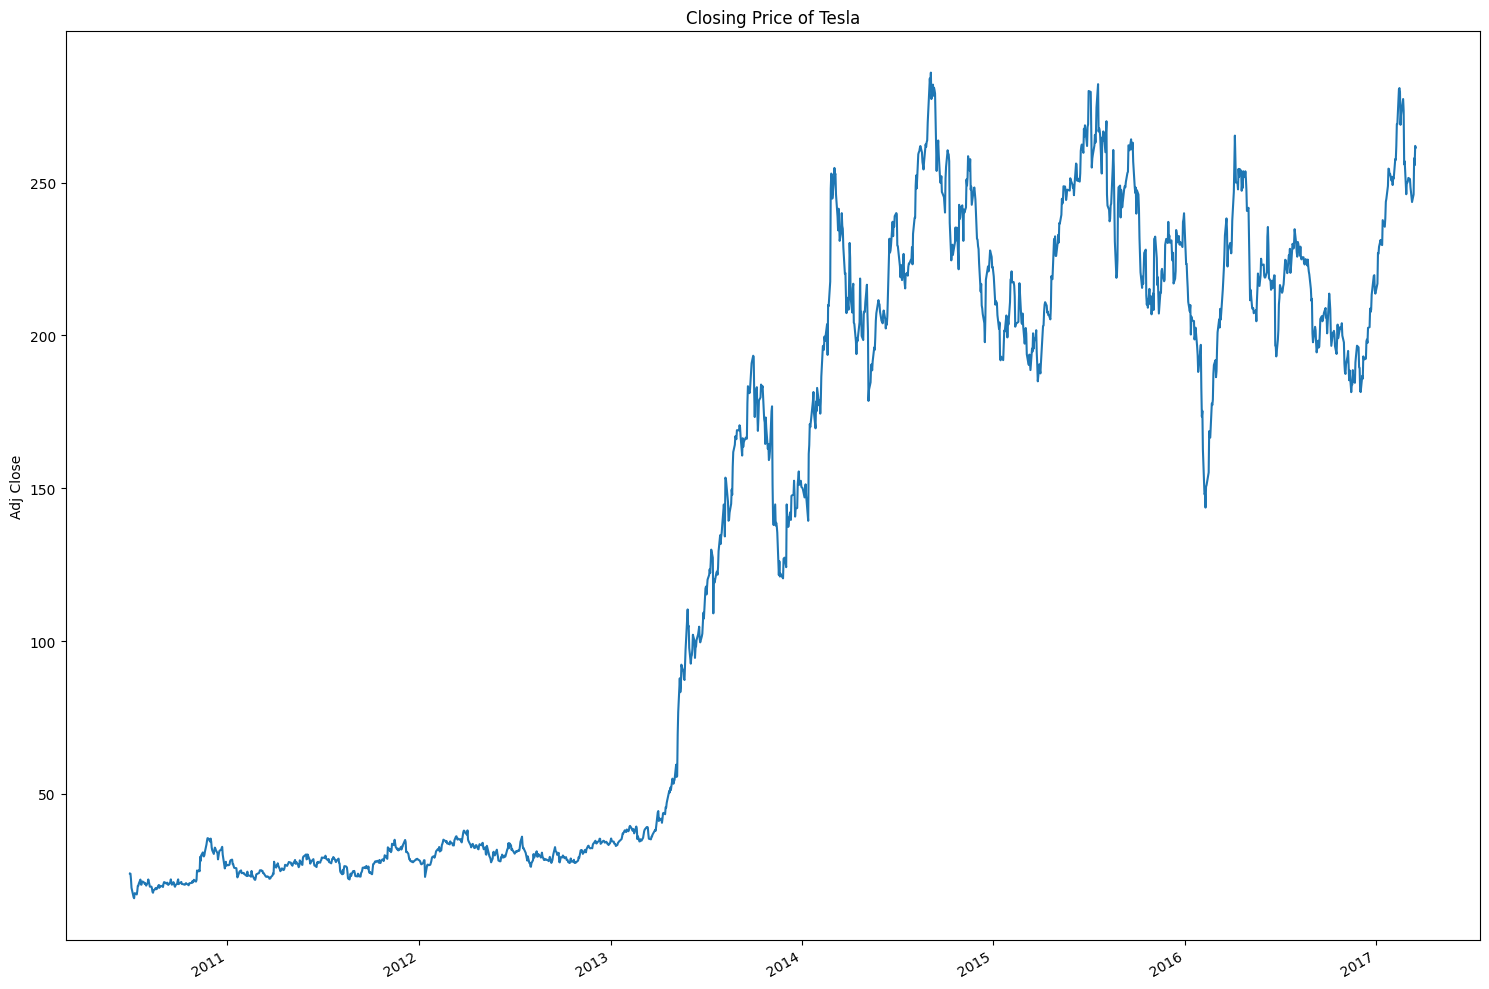

In [12]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
# plt.subplots_adjust(top=1.25, bottom=1.2)

# plt.subplot(2, 2, i)
tesla_stocks['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of Tesla")
    
plt.tight_layout()

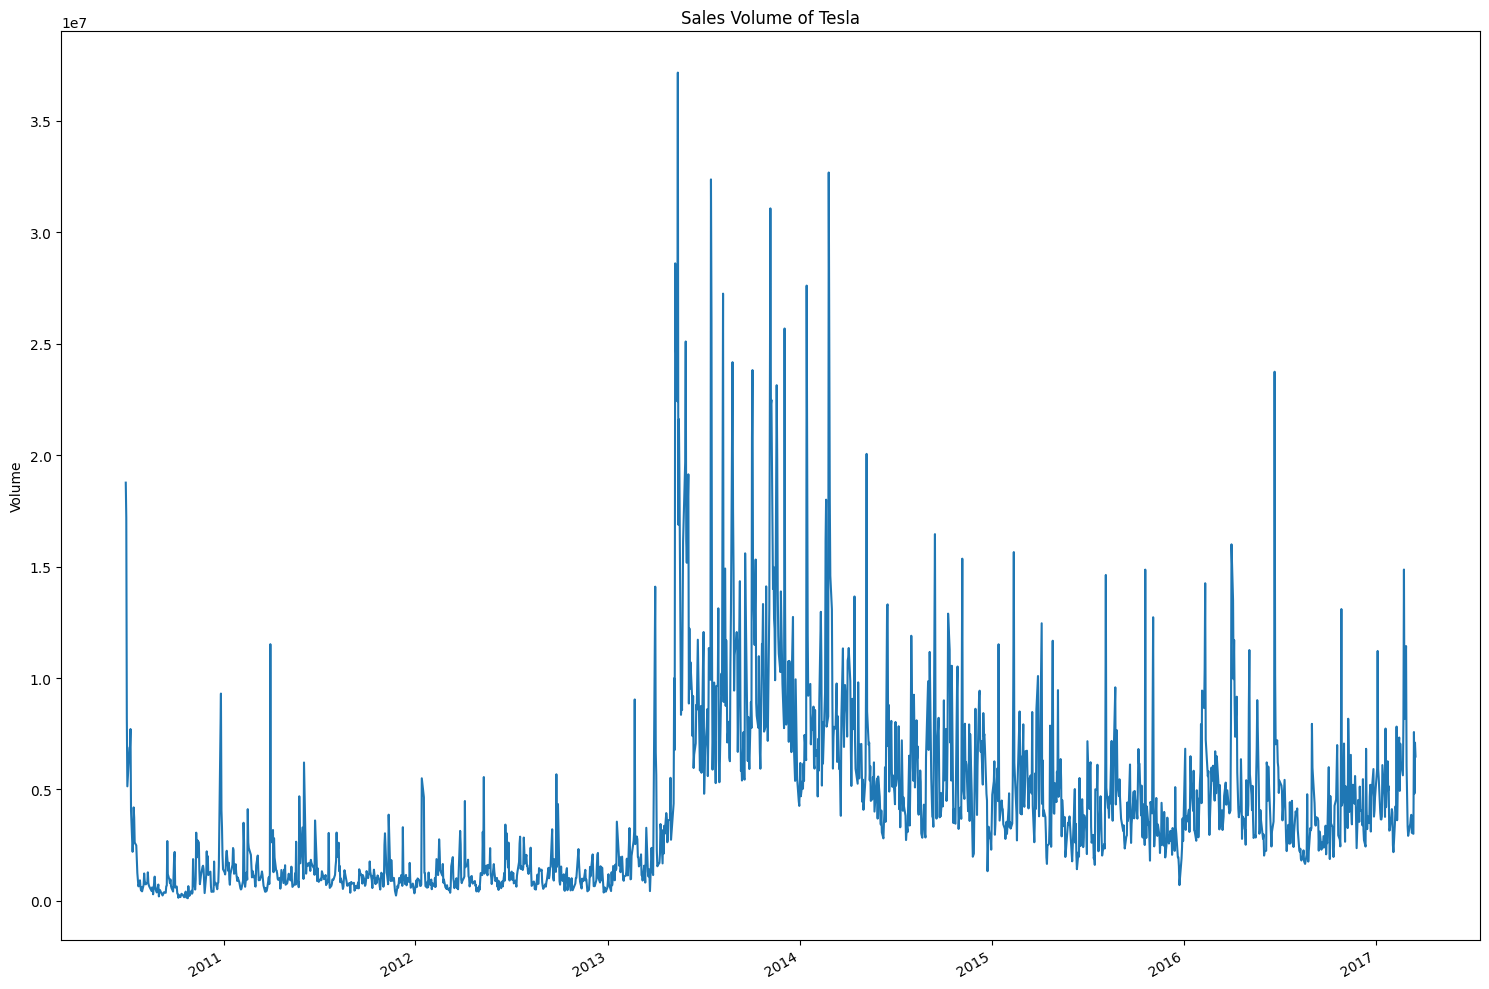

In [16]:
# Let's Plot total volume of stock being traded each day
plt.figure(figsize=(15, 10))
# plt.subplots_adjust(top=1.25, bottom=1.2)

# plt.subplot(2, 2, i)
tesla_stocks['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of Tesla")
    
plt.tight_layout()

In [30]:
# Lets calculate the trend of moving average of tesla stocks
# We can plot moving average considering specific period of time like 10, 20 days or weeks

def moving_average(stock_data, avg_window_list):
    for window in avg_window_list:
        clm_name = f'MA_AdjClose_{window}_days'
        stock_data[clm_name] = stock_data['Adj Close'].rolling(window).mean()
    
    return stock_data


    
avg_window_list_days = [10, 20, 50]

tesla_stocks_MA = moving_average(tesla_stocks, avg_window_list_days)
tesla_stocks_MA.head(20)

,Open,High,Low,Close,Volume,Adj Close,MA_AdjClose_10_days,MA_AdjClose_20_days,MA_AdjClose_50_days
Date,,,,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999,NaN,NaN,NaN
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000,NaN,NaN,NaN
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999,NaN,NaN,NaN
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001,NaN,NaN,NaN
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001,NaN,NaN,NaN
2010-07-07,16.400000,16.629999,14.980000,15.800000,6921700,15.800000,NaN,NaN,NaN
2010-07-08,16.139999,17.520000,15.570000,17.459999,7711400,17.459999,NaN,NaN,NaN
2010-07-09,17.580000,17.900000,16.549999,17.400000,4050600,17.400000,NaN,NaN,NaN
2010-07-12,17.950001,18.070000,17.000000,17.049999,2202500,17.049999,NaN,NaN,NaN


<Axes: xlabel='Date'>

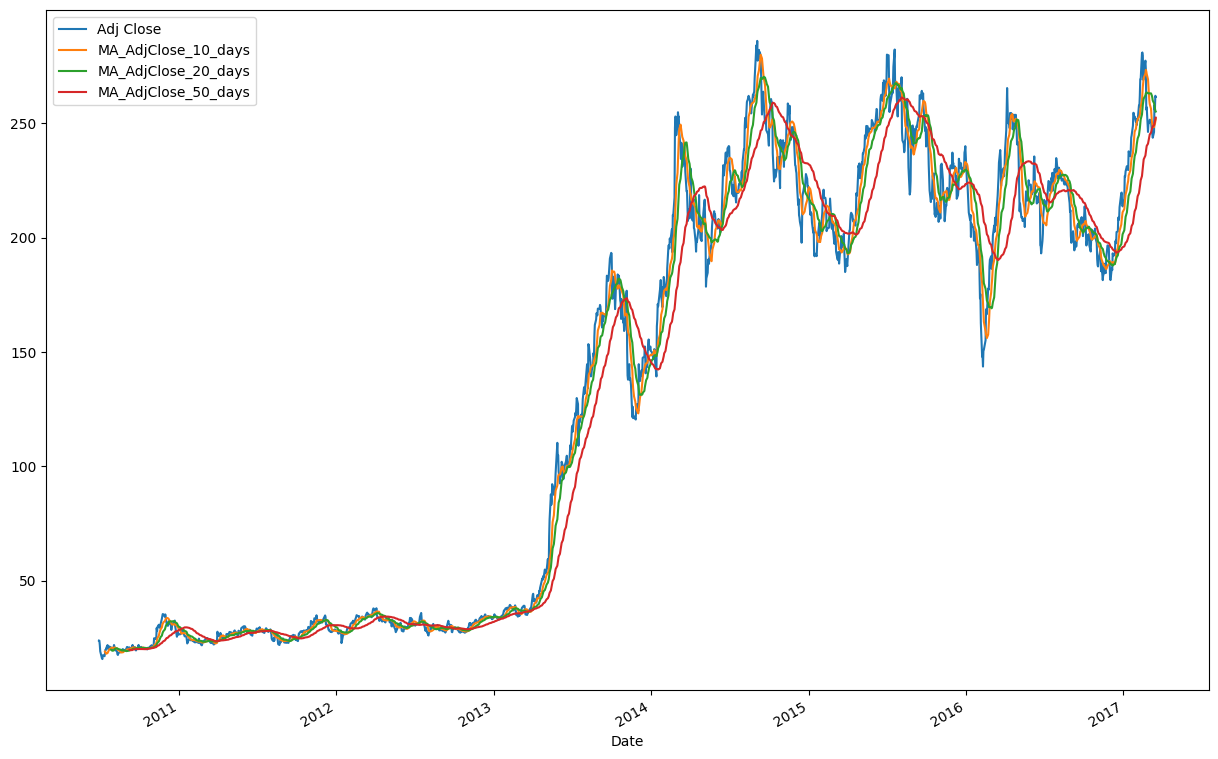

In [31]:
tesla_stocks_MA[[
    'Adj Close', 'MA_AdjClose_10_days', 'MA_AdjClose_20_days',
    'MA_AdjClose_50_days'
]].plot(figsize = (15,10))

In [32]:
# Let's track daily pct_change of the stock value

tesla_stocks_MA['Daily Return'] = tesla_stocks_MA['Adj Close'].pct_change()

Text(0.5, 1.0, 'Tesla (Daily % change)')

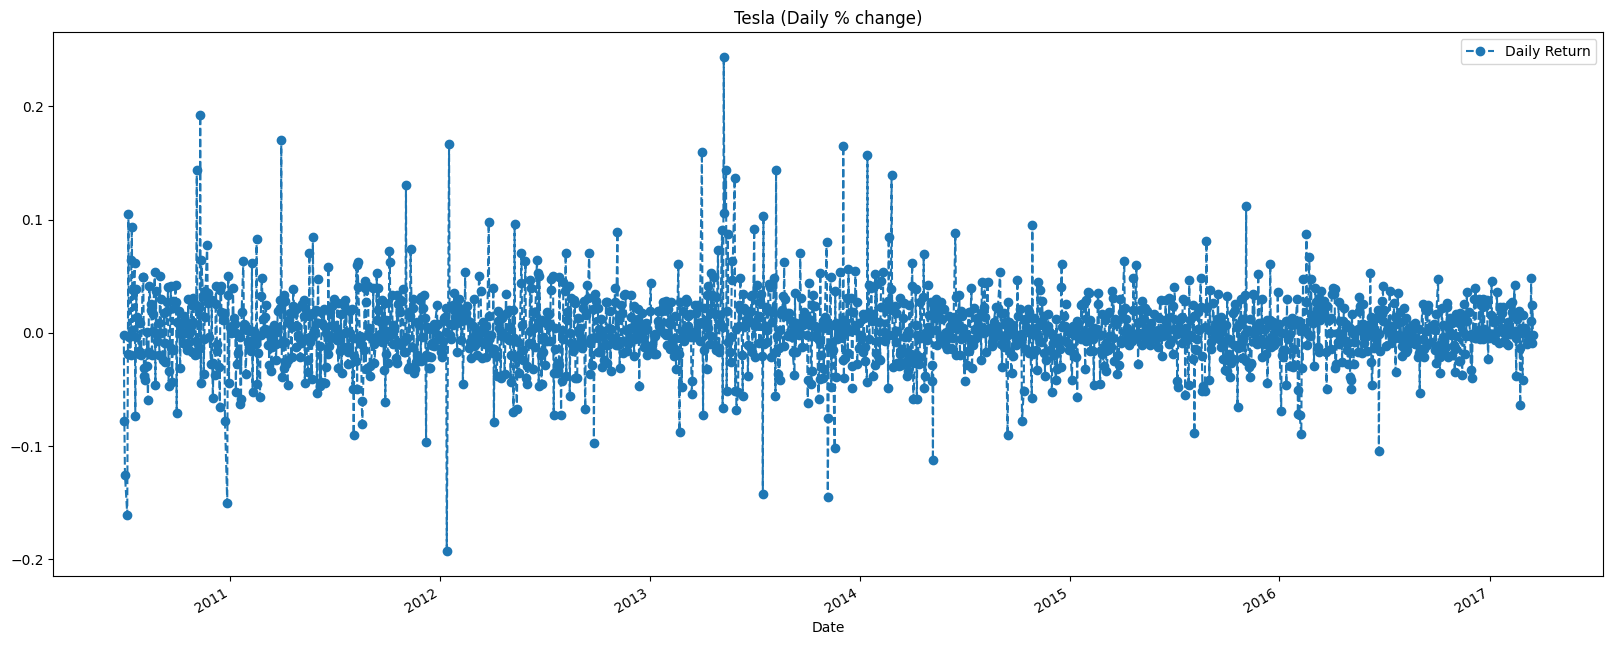

In [39]:
tesla_stocks_MA['Daily Return'].plot(legend=True, linestyle='--', marker='o', figsize=(20,8))
plt.title('Tesla (Daily % change)')

Text(0.5, 1.0, 'Tesla (Daily % change)')

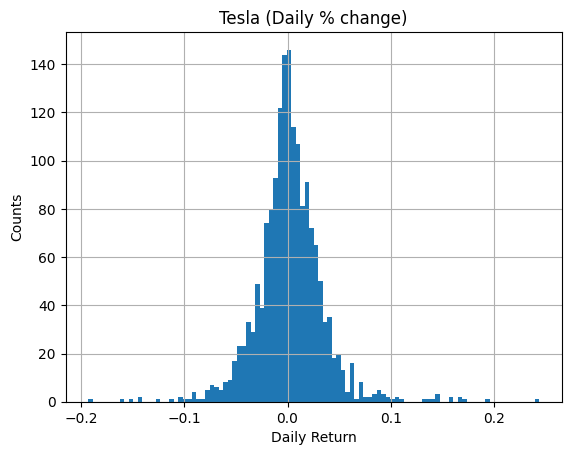

In [43]:
# Lets look at histogram if we can observe any trend
tesla_stocks_MA['Daily Return'].hist(bins=100)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Tesla (Daily % change)')

Text(0, 0.5, 'Risk')

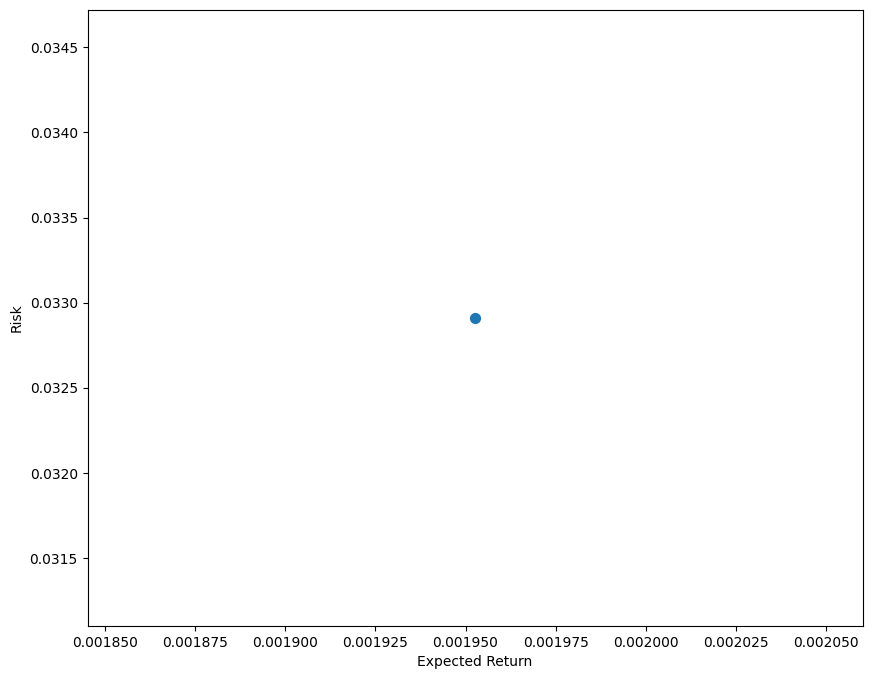

In [45]:
# We can analyse the risk for the stock by looking standard deviation in percentage change

plt.figure(figsize=(10, 8))
plt.scatter(tesla_stocks_MA['Daily Return'].mean(),
            tesla_stocks_MA['Daily Return'].std(),
            s=50)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

## Predictin the closing price stock of Tesla

In [93]:
tesla_stocks = tesla_stocks_MA.filter(['Close']).values
tesla_stocks

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [255.729996],
       [262.049988],
       [261.5     ]])

In [94]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(tesla_stocks)
scaled_data

array([[0.02993635],
       [0.02971433],
       [0.02279455],
       ...,
       [0.88784039],
       [0.91122698],
       [0.9091918 ]])

In [108]:
training_data_len = int(np.ceil(len(tesla_stocks) * .95))
split_range = 60

train_tesla = scaled_data[0:training_data_len,:]
test_tesla = scaled_data[training_data_len - split_range: , :]
                        
len(tesla_stocks), len(train_tesla), len(test_tesla)

(1692, 1608, 144)

In [103]:
# Split the data into x_train and y_train data sets

# converting data into sequence of arrays 

def convert_to_sequence(df, split_range):
    x_train = []
    y_train = []
    for i in range(split_range, len(df)):
        x_train.append(df[i-60:i, 0])
        y_train.append(df[i, 0])

    return x_train, y_train

x_train, y_train = convert_to_sequence(train_tesla, 60)

In [104]:
# Convert the x_train, y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [105]:
x_train[0].shape, y_train[0]

((60,), 0.013913554154743983)

In [106]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [107]:
x_train[0].shape

(60, 1)

In [77]:
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical

In [140]:
# create a simple 2 layer sequential neural net
model = Sequential()
model.add(Dense(128, input_dim=60, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1548/1548 [==============================] - 6s 4ms/step - loss: 0.0093


In [141]:
# Converting test data into same sequence format
x_test, y_test = convert_to_sequence(test_tesla, split_range)

# Convert the x_train, y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

print("test data sample shape:", x_test[0].shape, y_test[0])

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

print("Reshaped test data shape:", x_test[0].shape)

test data sample shape: (60,) 0.621558608666269
Reshaped test data shape: (60, 1)


In [142]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 0s 4ms/step


228.73946162817592

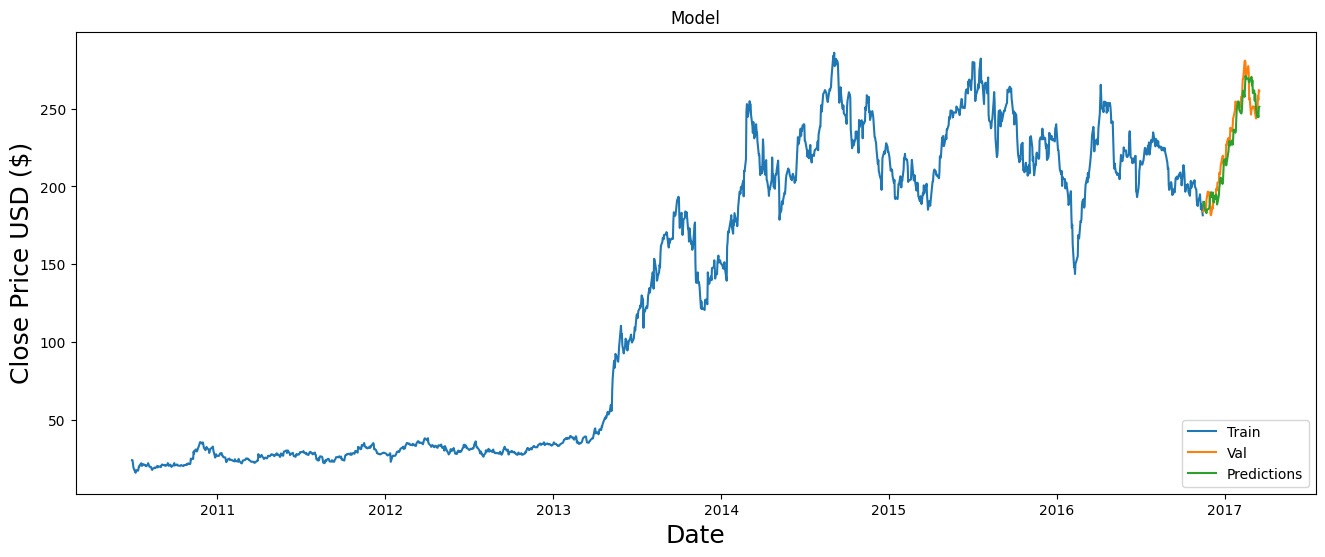

In [144]:
def plotting_pred(df, training_data_len, predictions):
    
    # Plot the data
    train = df[:training_data_len]
    valid = df[training_data_len:]
    valid['Predictions'] = predictions
    
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    
    return None

plotting_pred(tesla_stocks_MA, training_data_len, predictions )


In [136]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1548/1548 [==============================] - 20s 12ms/step - loss: 0.0024


In [138]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 0s 10ms/step


212.69253811491888

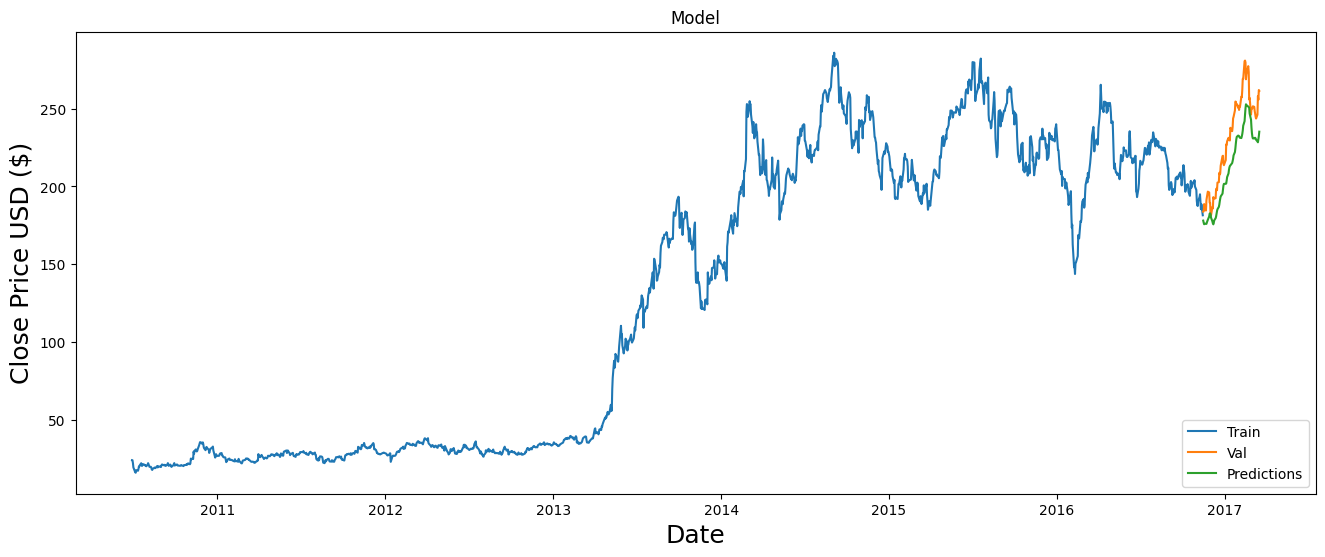

In [139]:
plotting_pred(tesla_stocks_MA, training_data_len, predictions )

In [145]:
# Build the GRU model
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(GRU(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1548/1548 [==============================] - 21s 12ms/step - loss: 0.0016


In [146]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 [==============================] - 0s 32ms/step


240.75560623262976

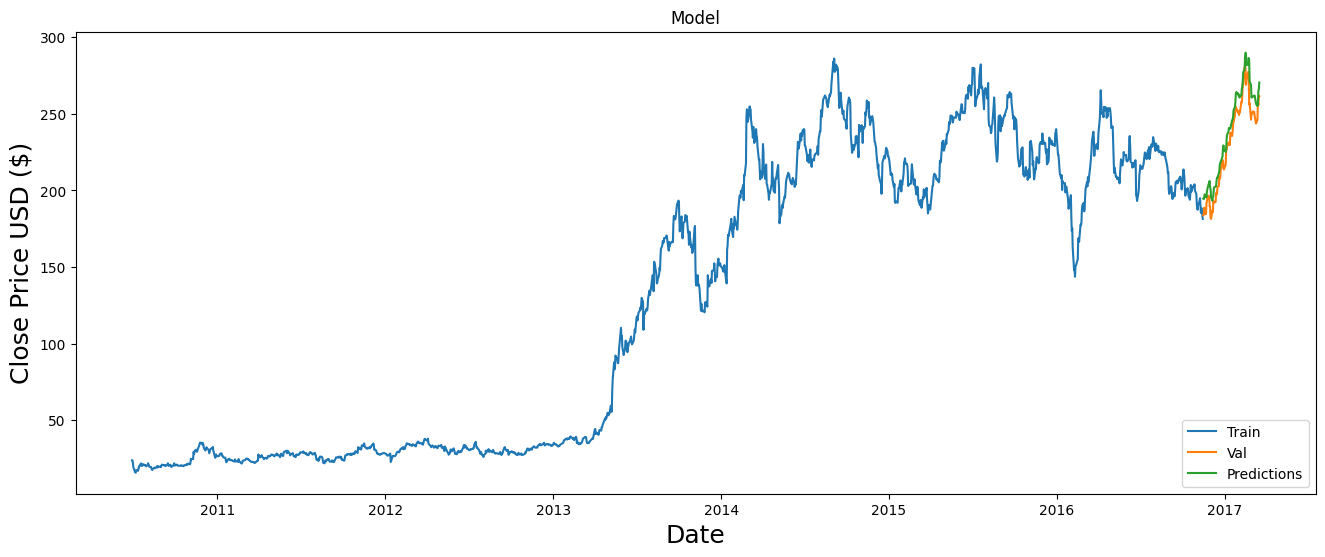

In [147]:
plotting_pred(tesla_stocks_MA, training_data_len, predictions )